In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../src')
from preprocessing import *
from utils import *
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from plotting import *

In [3]:
df_db = group_datafiles_byID('../datasets/raw/HT_Sensor_metadata.dat', '../datasets/raw/HT_Sensor_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [5]:
df_train, df_test = split_series_byID(0.75, df_db)

In [6]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
xtrain, ytrain = df_train[features].values, df_train['class'].values
xtest, ytest = df_test[features].values, df_test['class'].values

## Radial Basis Function

In [7]:
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(xtrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = rbf_feature.fit_transform(xtest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7658983203295701
Recall on background: 1.0
Recall on banana: 0.0
Recall on wine: 0.0
F1-score: 0.66436468094514


(0.7658983203295701, 1.0, 0.0, 0.0, 0.66436468094514)

## Additive Chi 2

In [8]:
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_transformed, ytrain)

X_features = chi2sampler.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7511635504304182
Recall on background: 0.9407887083640312
Recall on banana: 0.015528125352271447
Recall on wine: 0.3384279475982533
F1-score: 0.6966520774385728


(0.7511635504304182,
 0.9407887083640312,
 0.015528125352271447,
 0.3384279475982533,
 0.6966520774385728)

## Skewed Chi 2

In [9]:
chi2_feature = SkewedChi2Sampler(skewedness=.01, n_components=10, random_state=0)
X_features = chi2_feature.fit_transform(xtrain, ytrain)
clf = SGDClassifier(max_iter=100, tol=1e-4)
clf.fit(X_features, ytrain)

X_features = chi2_feature.fit_transform(xtest, ytest)
ytrue = clf.predict(X_features)
metric_report(ytest, ytrue)

TEST SET PROPORTIONS:
	Real background percentage: 0.7658983203295701
	Real banana percentage: 0.15054666717578627
	Real wine percentage: 0.08355501249464364
------------------------------------------
Accuracy: 0.7613035158951383
Recall on background: 0.9569417747323056
Recall on banana: 0.0
Recall on wine: 0.3396973697572865
F1-score: 0.6932812480702728


(0.7613035158951383,
 0.9569417747323056,
 0.0,
 0.3396973697572865,
 0.6932812480702728)

## Hiperparámetros SKEWED

In [10]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

In [29]:
SKEW = [.0001, .001, .01, .05, .1]
NCOMP = [20, 40, 80, 100, 200, 500]

In [30]:
for skew in SKEW:
    for ncomp in NCOMP:
        df_train, df_test = split_series_byID(0.75, df_db)
        features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
        xtrain, ytrain = df_train[features].values, df_train['class'].values
        xtest, ytest = df_test[features].values, df_test['class'].values
            
        chi2_feature = SkewedChi2Sampler(skewedness=skew, n_components=ncomp, random_state=0)
        clf = SGDClassifier(max_iter=500, tol=1e-4)
        
        start_t = time.time()
        X_features = chi2_feature.fit_transform(xtrain, ytrain)
        clf.fit(X_features, ytrain)
        end_t = time.time()

        X_features = chi2_feature.fit_transform(xtest, ytest)
        ytrue = clf.predict(X_features)
        print("\n\n")
        print("Skew: %.3f" % (skew) + " Ncomp: %d" % (ncomp))
        print("Time: %.3f" % ((end_t-start_t)/60))
        metric_report(ytest, ytrue)
            




Skew: 0.000 Ncomp: 20
Time: 0.089
TEST SET PROPORTIONS:
	Real background percentage: 0.822545504159223
	Real banana percentage: 0.0767249796409126
	Real wine percentage: 0.10072951619986442
------------------------------------------
Accuracy: 0.8592899261956434
Recall on background: 0.9706508949351801
Recall on banana: 0.0
Recall on wine: 0.6044444444444445
F1-score: 0.8228033087518296



Skew: 0.000 Ncomp: 40
Time: 0.115
TEST SET PROPORTIONS:
	Real background percentage: 0.7408992189152896
	Real banana percentage: 0.10665325279251817
	Real wine percentage: 0.15244752829219219
------------------------------------------
Accuracy: 0.8085284605852306
Recall on background: 0.9668343114229602
Recall on banana: 0.0
Recall on wine: 0.6048092446257116
F1-score: 0.7580628841285102



Skew: 0.000 Ncomp: 80
Time: 0.176
TEST SET PROPORTIONS:
	Real background percentage: 0.7071219725247395
	Real banana percentage: 0.10452245861928121
	Real wine percentage: 0.18835556885597932
-------------------

F1-score: 0.6856901536376944



Skew: 0.010 Ncomp: 500
Time: 0.605
TEST SET PROPORTIONS:
	Real background percentage: 0.7432107179212892
	Real banana percentage: 0.0767395917803965
	Real wine percentage: 0.18004969029831433
------------------------------------------
Accuracy: 0.8285641574216256
Recall on background: 0.9810624307179794
Recall on banana: 0.0
Recall on wine: 0.5522255761583058
F1-score: 0.7870079625131723



Skew: 0.050 Ncomp: 20
Time: 0.106
TEST SET PROPORTIONS:
	Real background percentage: 0.7602954651544752
	Real banana percentage: 0.11962103006517869
	Real wine percentage: 0.12008350478034611
------------------------------------------
Accuracy: 0.7819539772825504
Recall on background: 0.9692618174582871
Recall on banana: 0.0
Recall on wine: 0.3749775042292049
F1-score: 0.7207720843580083



Skew: 0.050 Ncomp: 40
Time: 0.138
TEST SET PROPORTIONS:
	Real background percentage: 0.7643509391317259
	Real banana percentage: 0.07447062996477741
	Real wine percentage: 0.161178

## Original (Simple y Bagging) 

In [16]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

### Simple

In [50]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 5
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, df_db)
    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))
    
end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))

>===============================================================<
Iteración 1 de 5
Training time (mins): 0.3096825122833252
>===============================================================<
>===============================================================<
Iteración 2 de 5
Training time (mins): 0.31048765579859416
>===============================================================<
>===============================================================<
Iteración 3 de 5
Training time (mins): 0.3177577455838521
>===============================================================<
>===============================================================<
Iteración 4 de 5
Training time (mins): 0.32534724871317544
>===============================================================<
>===============================================================<
Iteración 5 de 5
Training time (mins): 0.3253568172454834
>===============================================================<



>============================================

### Gráficas 

In [36]:
probs = model.predict_proba(X_features)

In [37]:
test_ids = list(set(df_test['id']))
print(test_ids)

[1, 8, 10, 11, 12, 15, 16, 26, 27, 29, 52, 53, 54, 57, 62, 64, 71, 79, 83, 92]


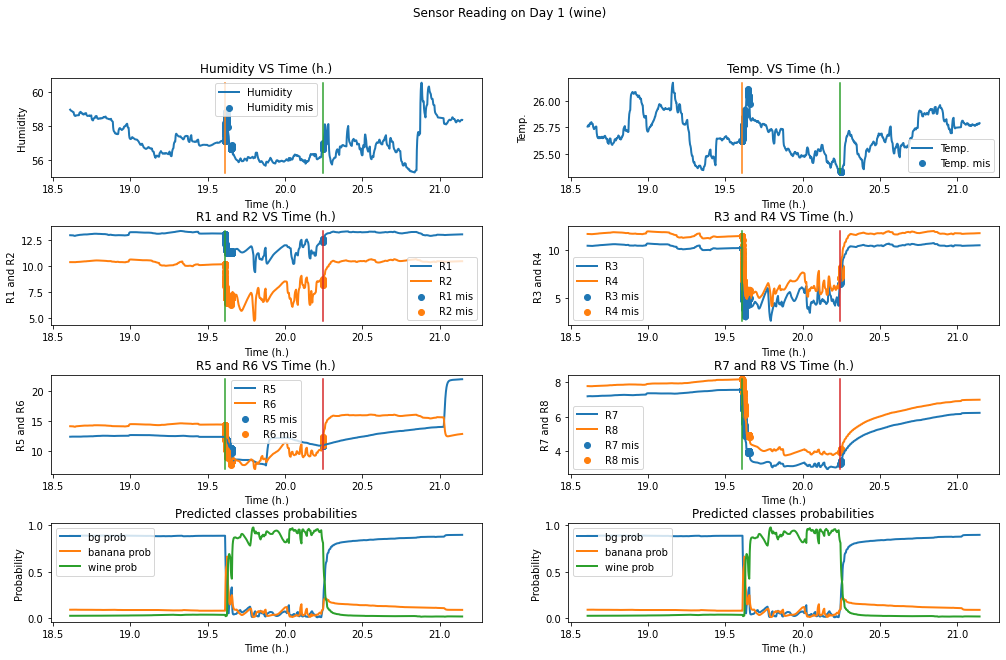

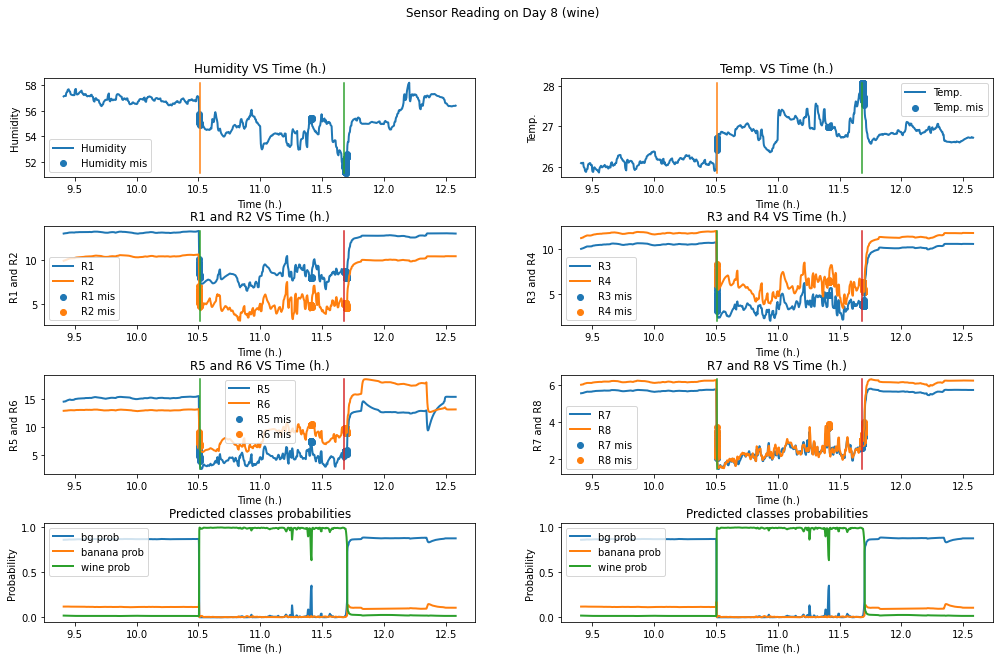

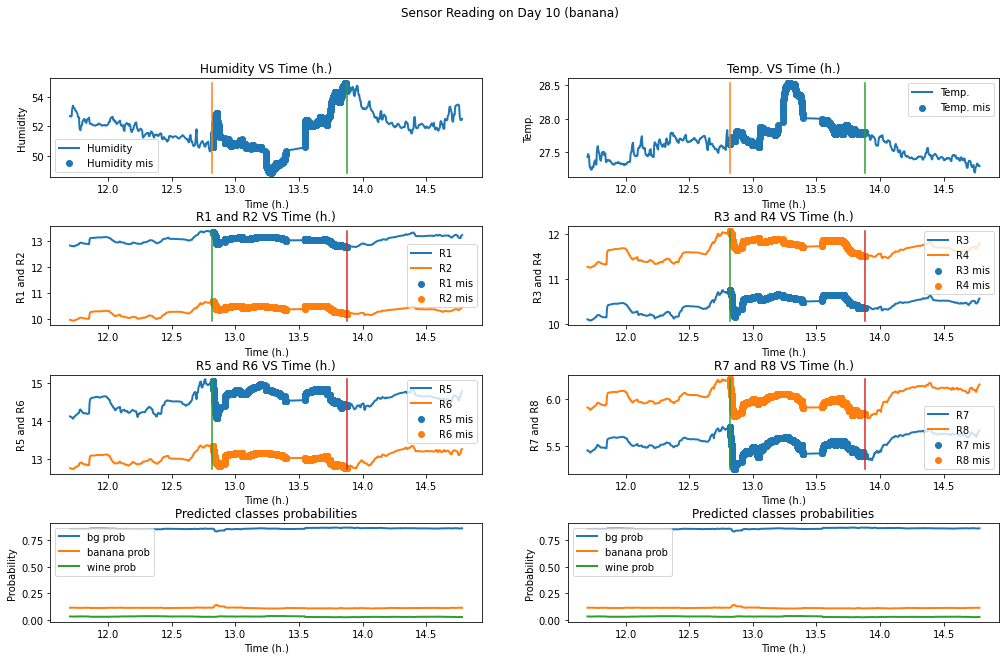

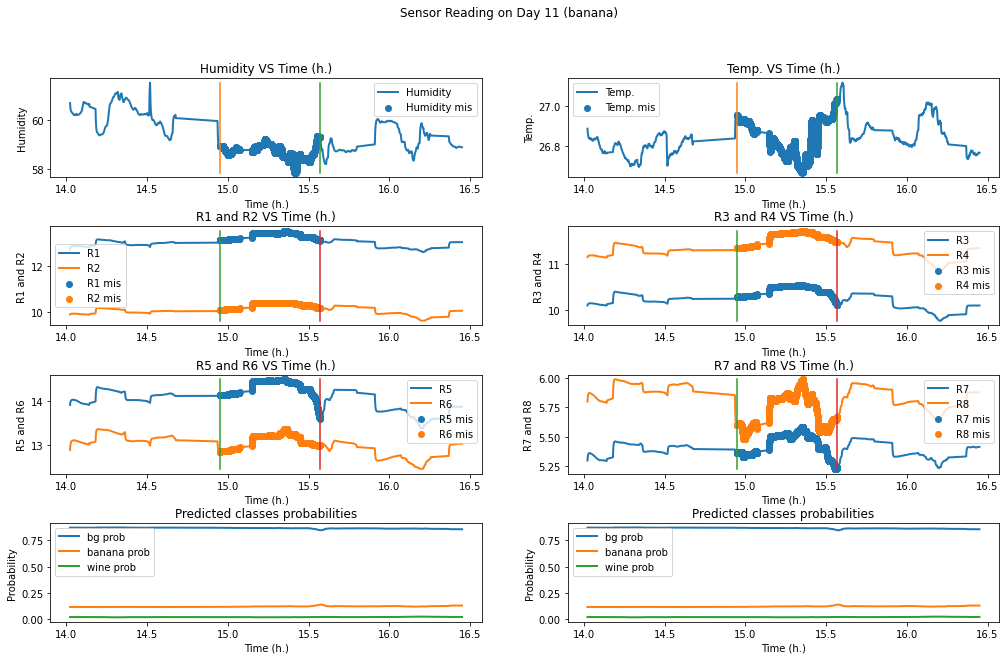

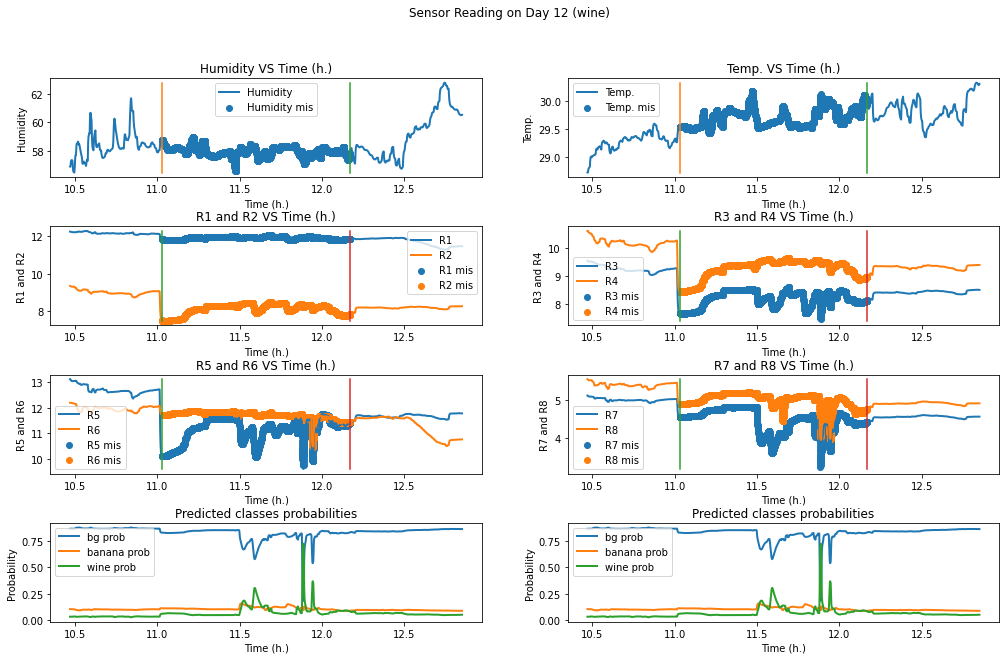

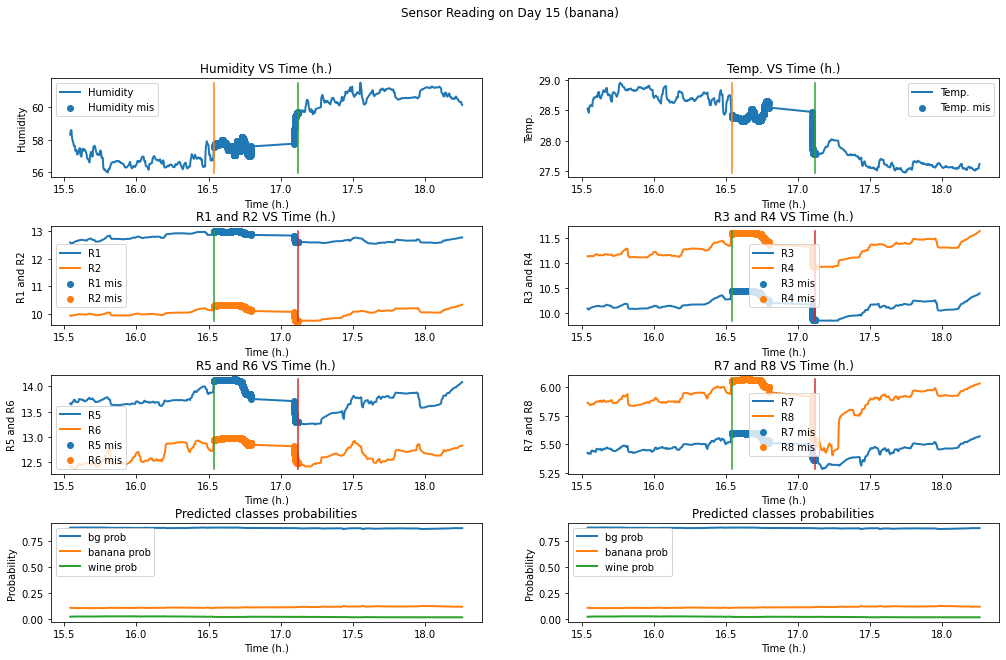

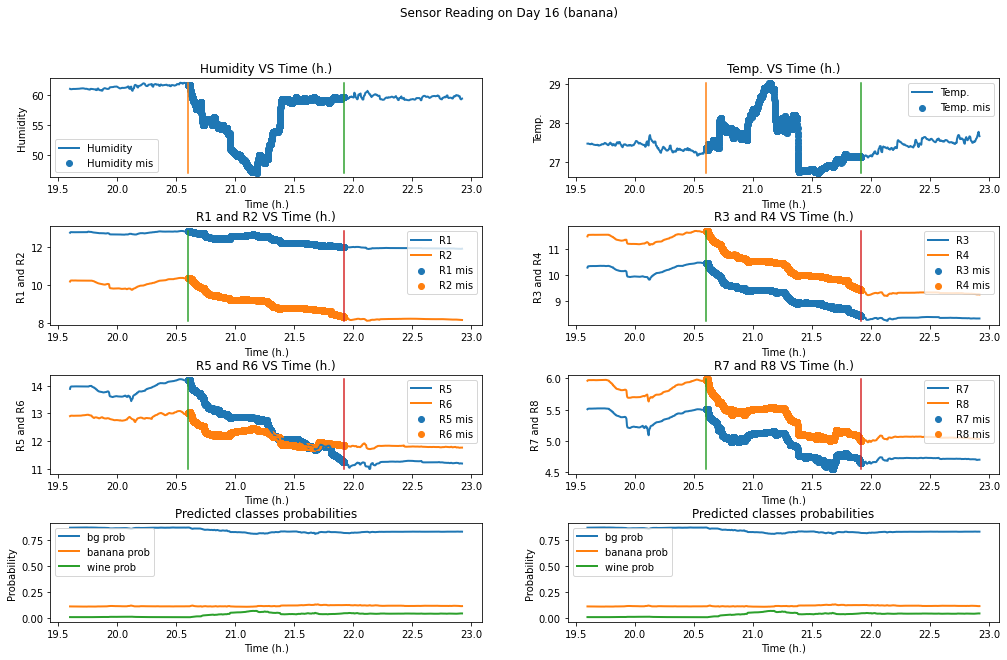

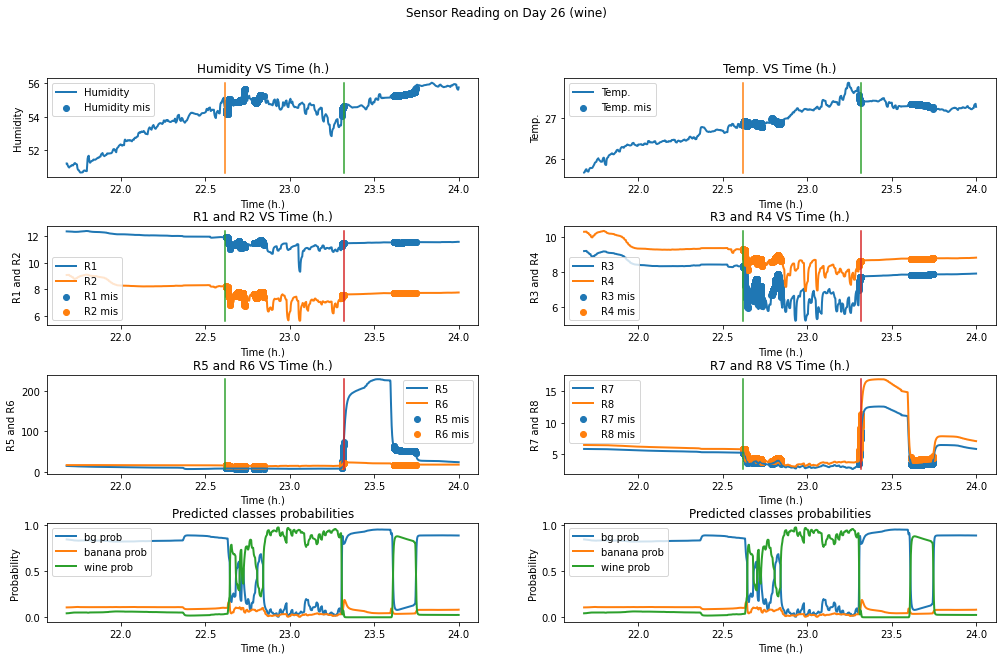

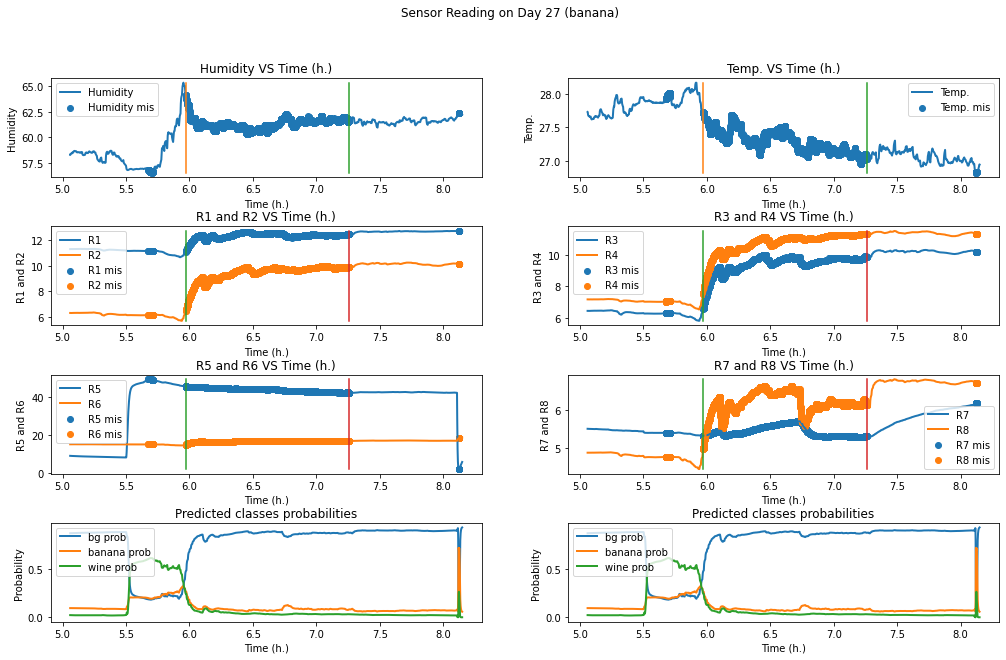

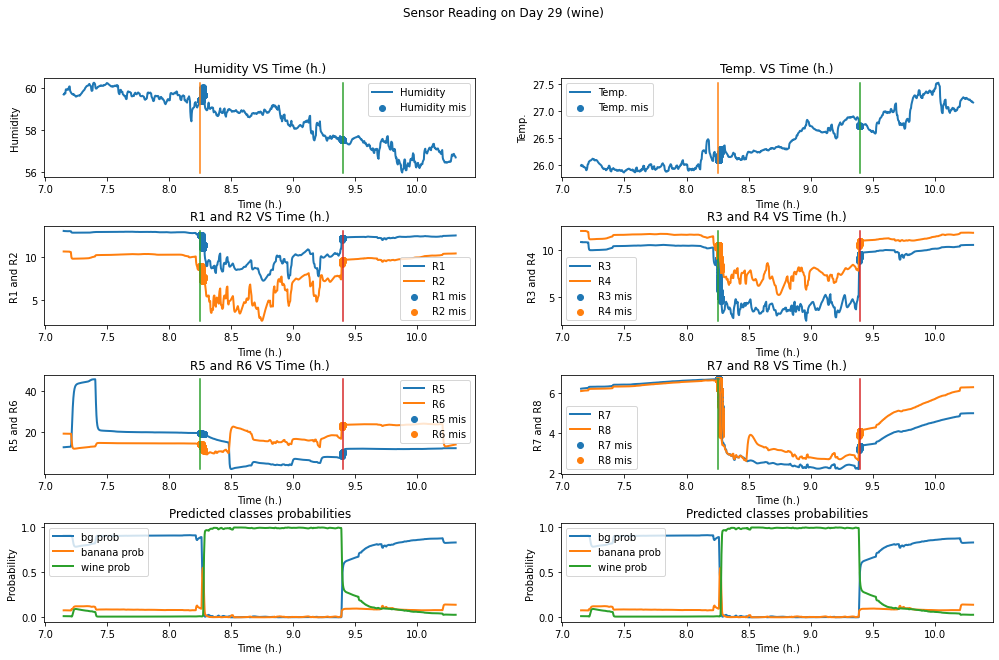

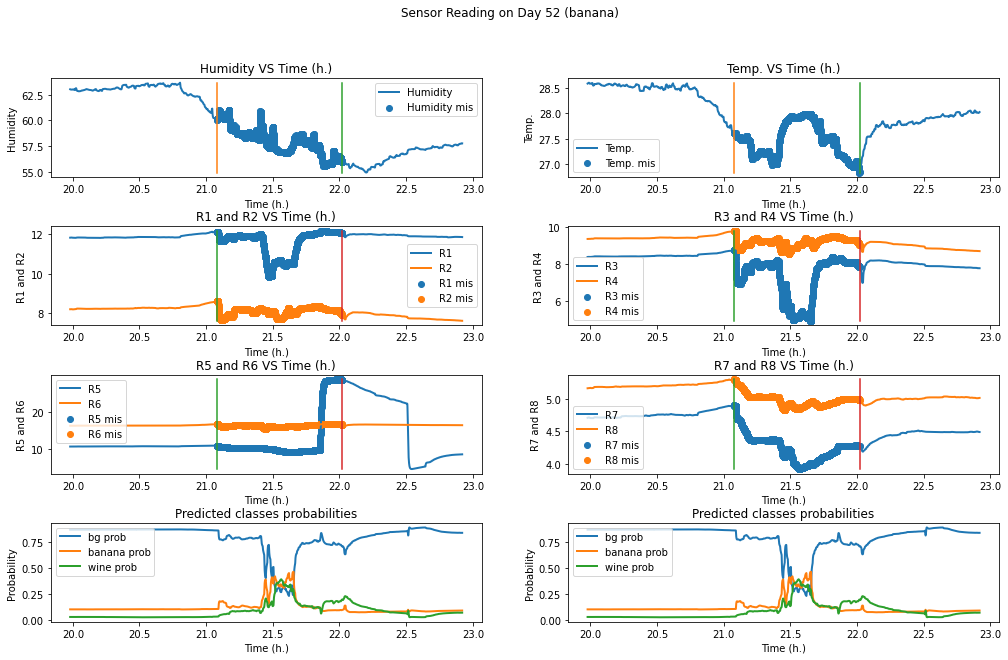

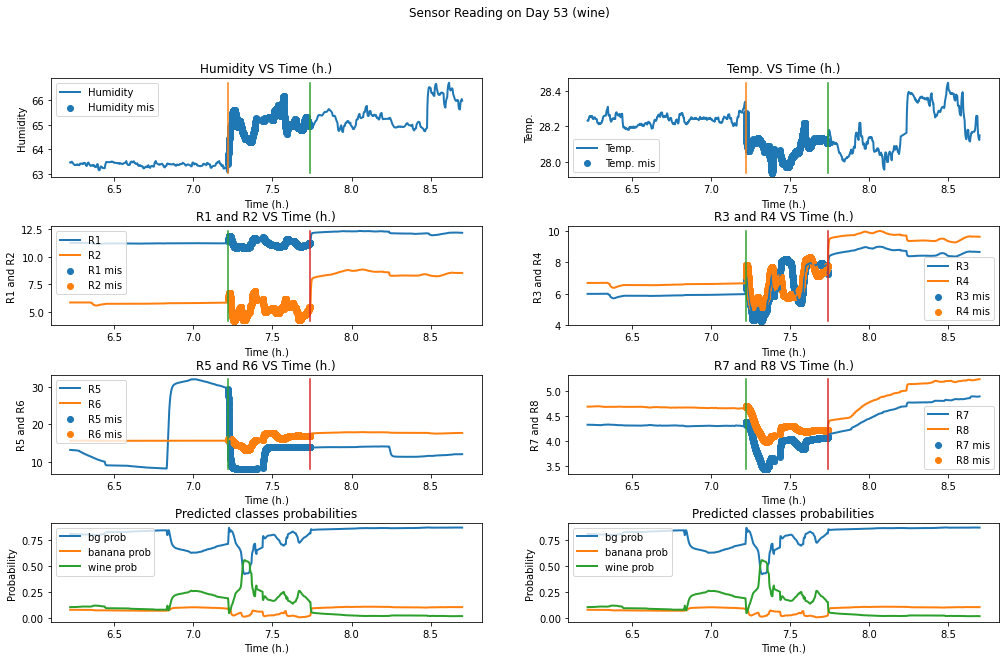

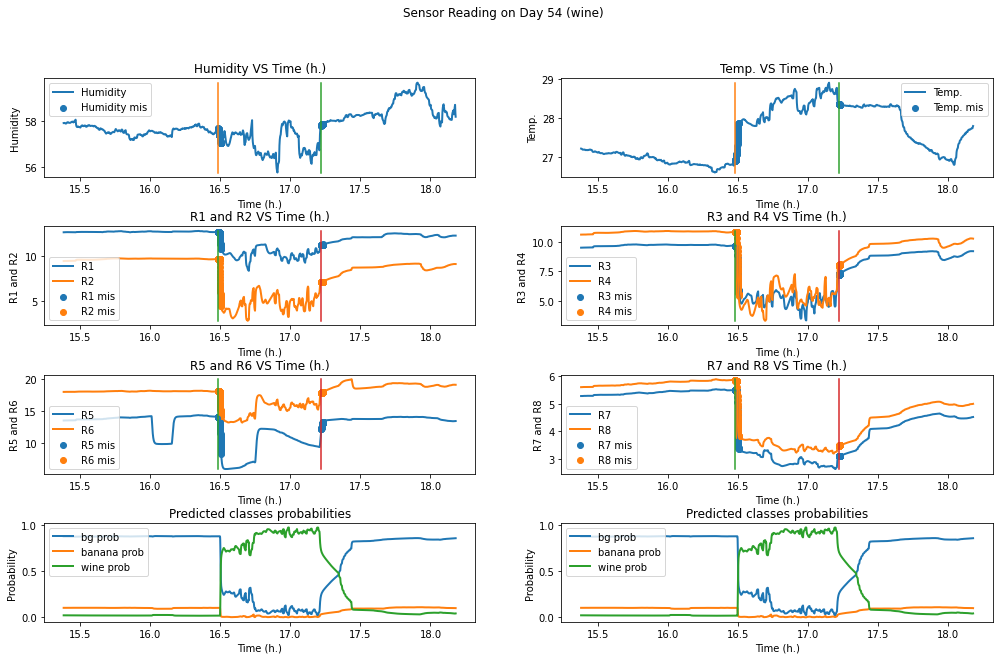

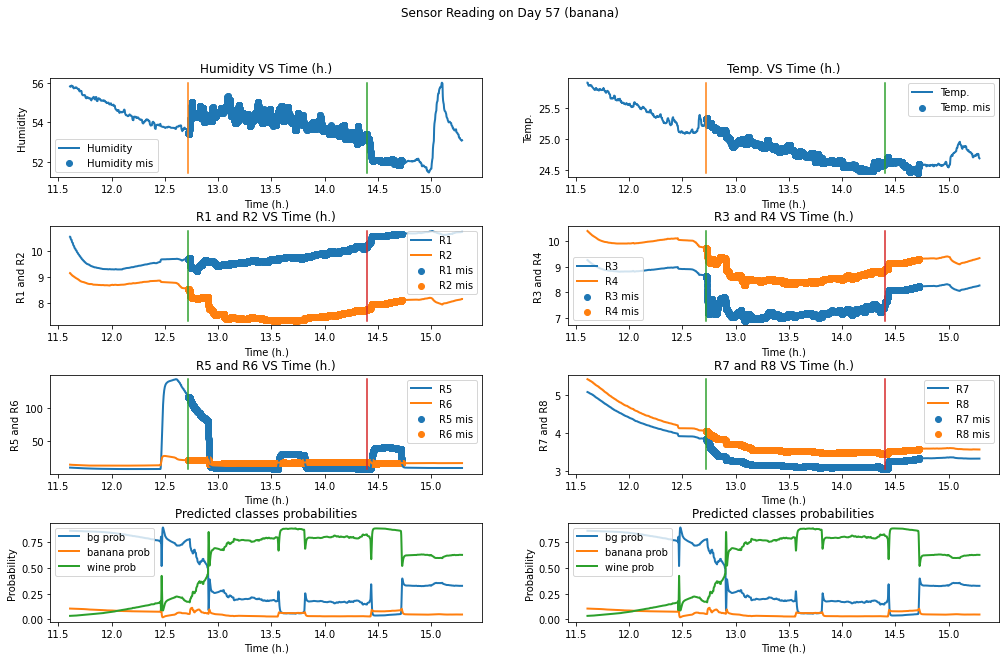

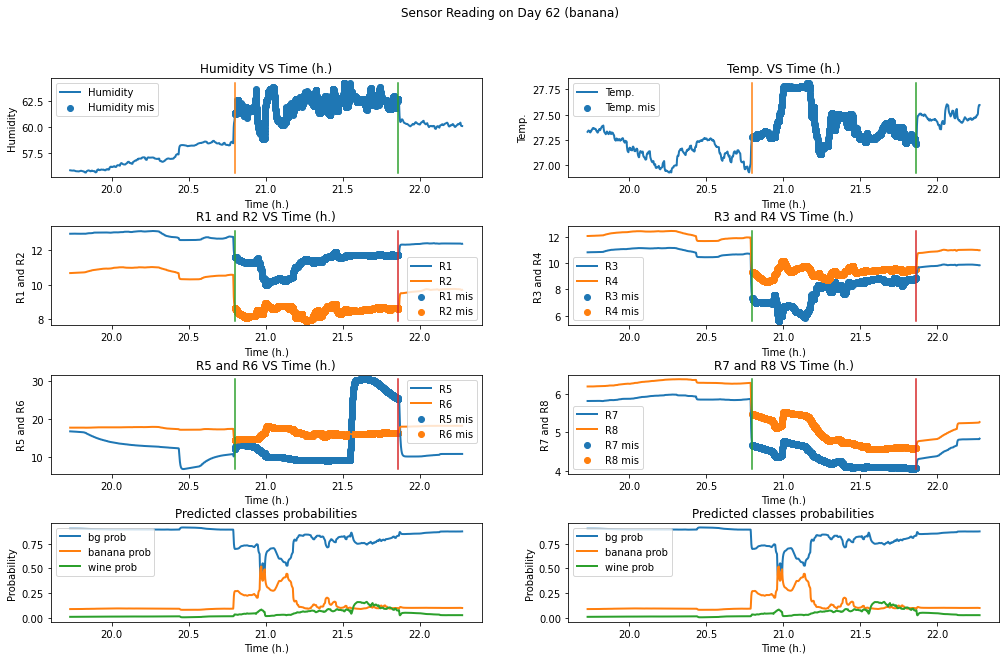

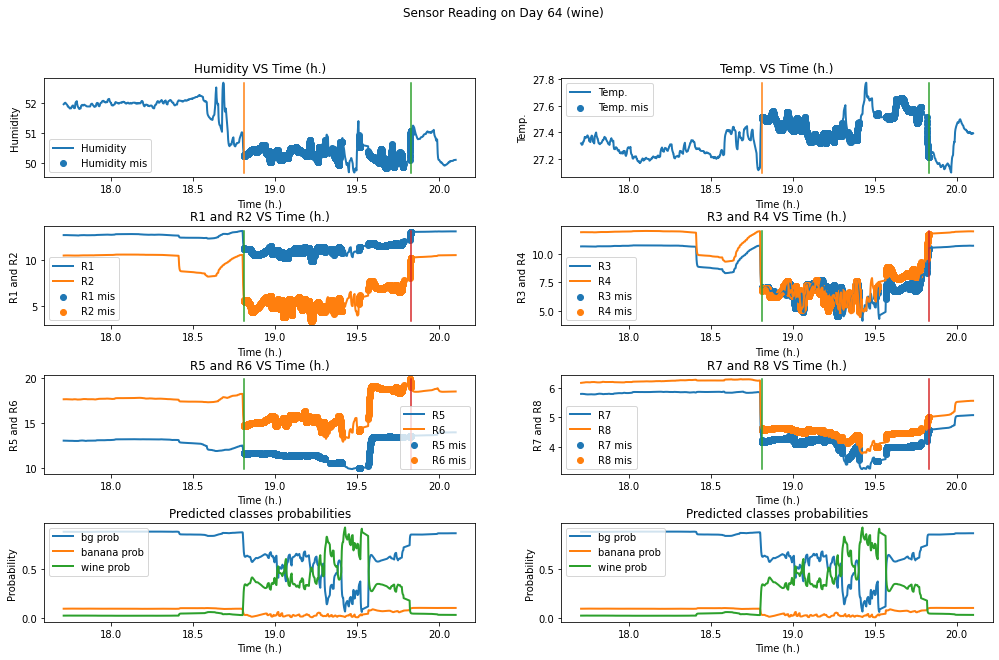

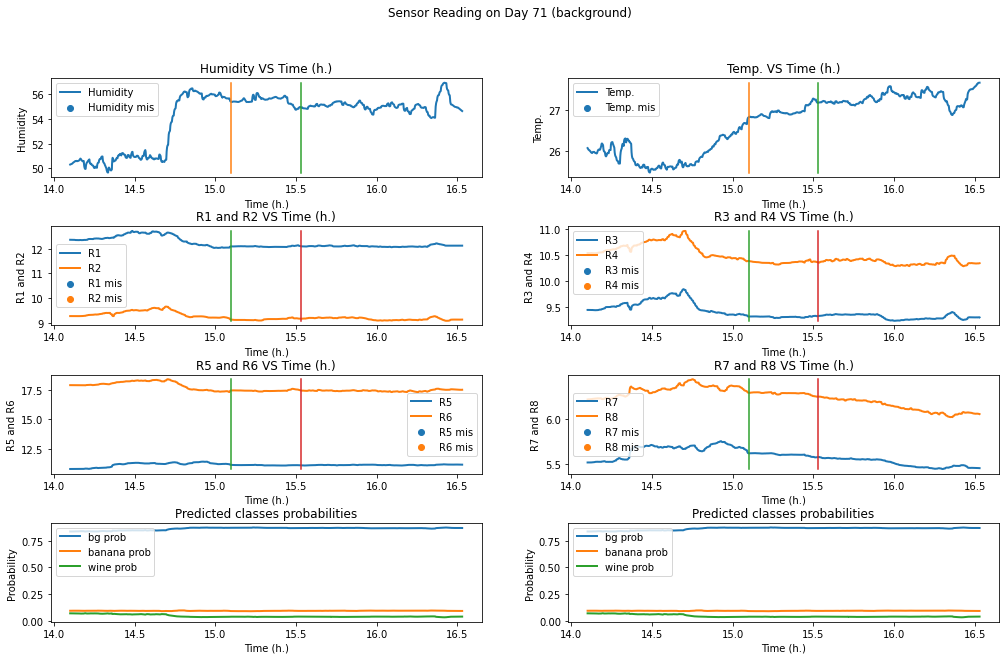

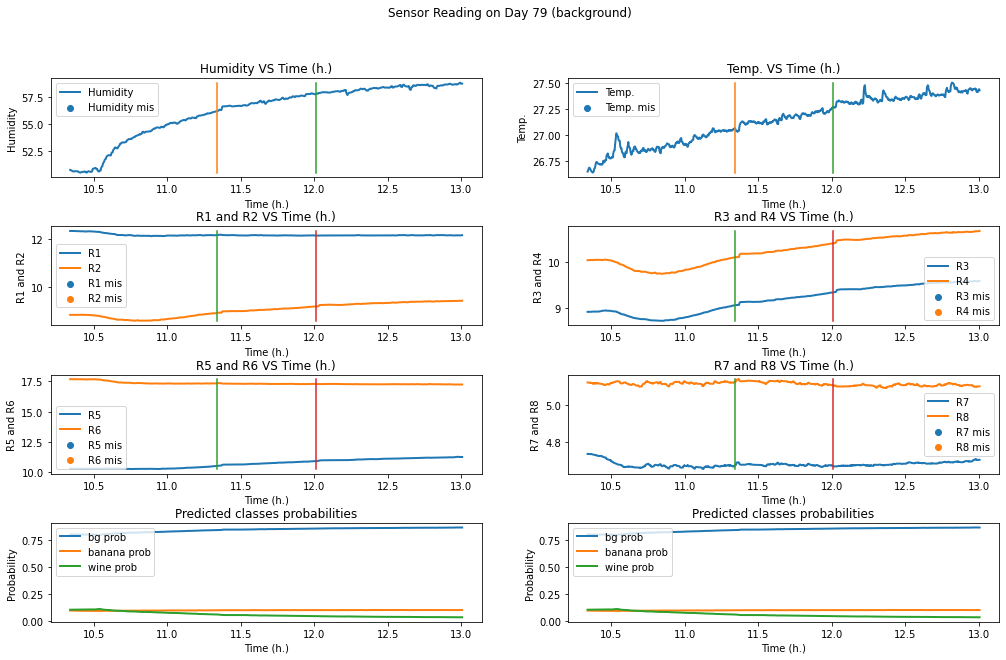

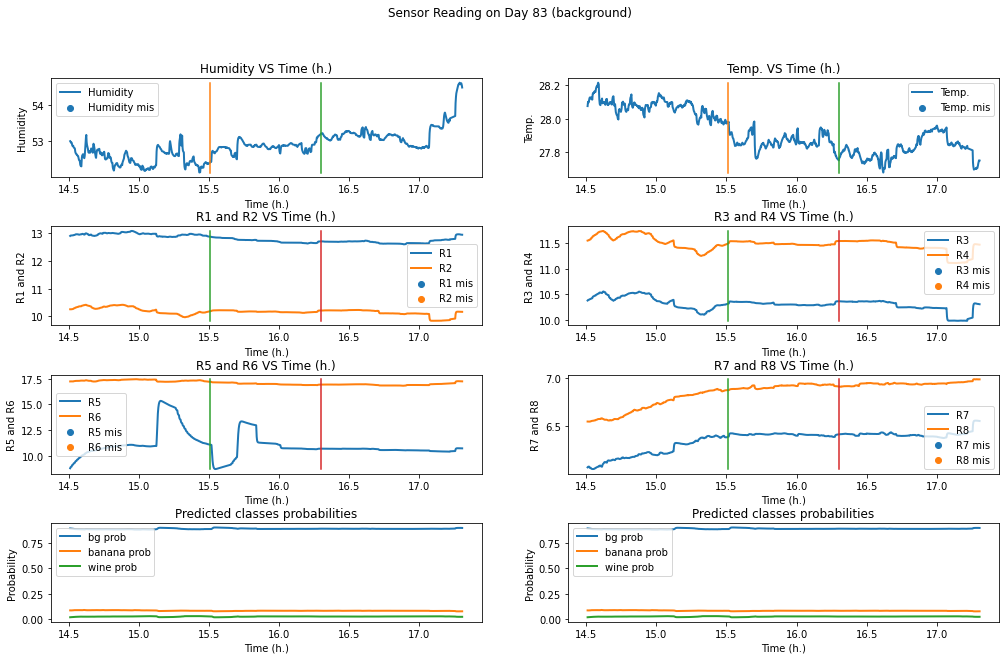

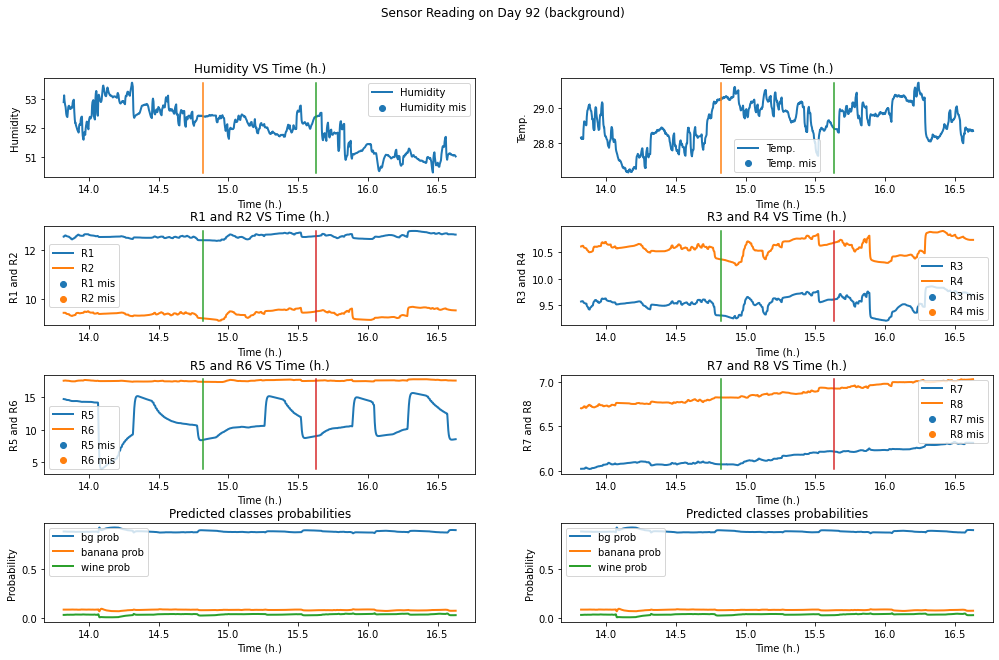

In [38]:
for tid in test_ids:
    plot_misclassified_byID(df_test, tid, ytest, y_pred, probs_mtx=probs)

### Bagging

In [43]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 3
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, df_db)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
    bc = BaggingClassifier(base_estimator=clf, n_estimators=500, n_jobs=1)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = bc.fit(X_features, ytrain)
    end_t = time.time()


    X_features = chi2_feature.fit_transform(xtest, ytest)

    print('\n>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))

end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))


>===============================================================<
Iteración 1 de 3
Training time (mins): 184.09250374237698
>===============================================================<

>===============================================================<
Iteración 2 de 3
Training time (mins): 181.56651240984598
>===============================================================<

>===============================================================<
Iteración 3 de 3
Training time (mins): 436.3960923751195
>===============================================================<



>===============================================================<
Total time (mins): 823.9070331335067
>===============================================================<
Mean Accuracy: 0.7918509543323674
Mean Recall on background: 0.956474949624488
Mean Recall on banana: 0.0
Mean Recall on wine: 0.3913903708699927
Mean F1-score: 0.7377954487740208
>===============================================================<
TEST SET M

## WINDOWS-120 (Simple y Ensembles)

In [21]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_metadata.dat', '../datasets/preprocessed/HT_Sensor_preprocessed_dataset/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)
win_df = window_df(df_db, window_size=120)

In [39]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 5
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = clf.fit(X_features, ytrain)
    end_t = time.time()

    calibrator = CalibratedClassifierCV(clf, cv='prefit')
    model=calibrator.fit(X_features, ytrain)

    X_features = chi2_feature.fit_transform(xtest, ytest)
    sc = clf.score(X_features, ytest)

    print('>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))
    
end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))

>===============================================================<
Iteración 1 de 5
Training time (mins): 0.3396012783050537
>===============================================================<
>===============================================================<
Iteración 2 de 5
Training time (mins): 0.36864606936772665
>===============================================================<
>===============================================================<
Iteración 3 de 5
Training time (mins): 0.3128595312436422
>===============================================================<
>===============================================================<
Iteración 4 de 5
Training time (mins): 0.3373642126719157
>===============================================================<
>===============================================================<
Iteración 5 de 5
Training time (mins): 0.30751489798227943
>===============================================================<



>============================================

### Gráficas

In [40]:
probs = model.predict_proba(X_features)

In [41]:
test_ids = list(set(df_test['id']))
print(test_ids)

[2, 4, 18, 22, 23, 33, 35, 38, 39, 43, 47, 50, 52, 60, 61, 69, 72, 75, 88, 96]


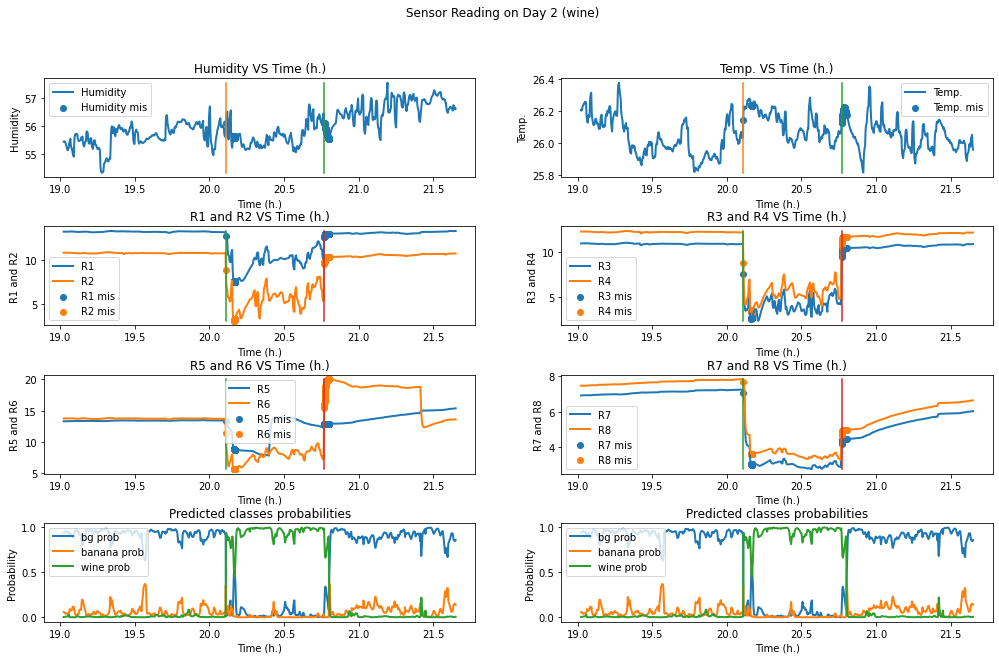

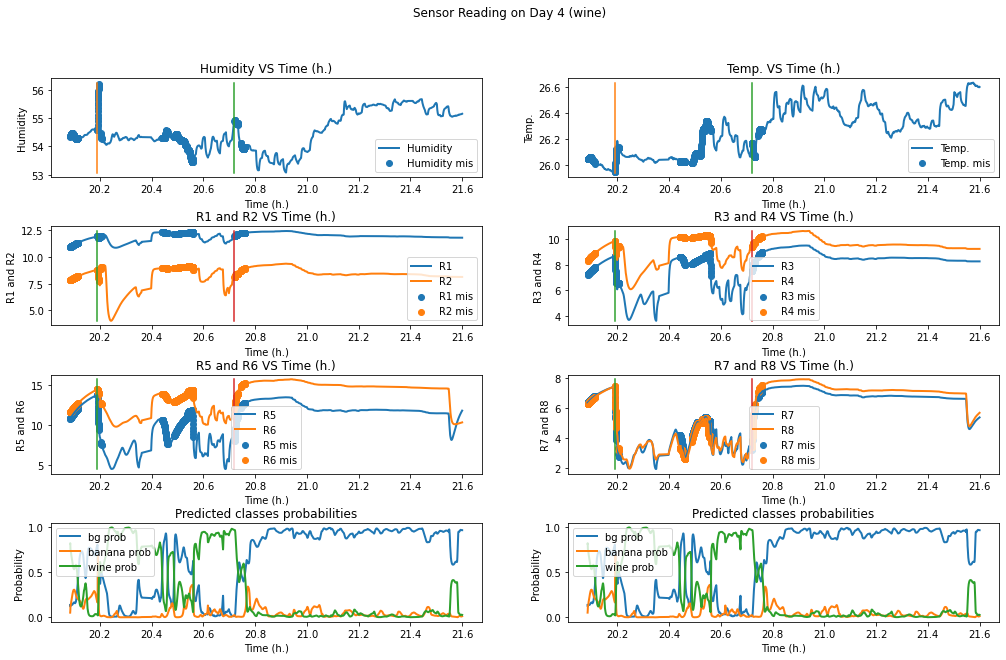

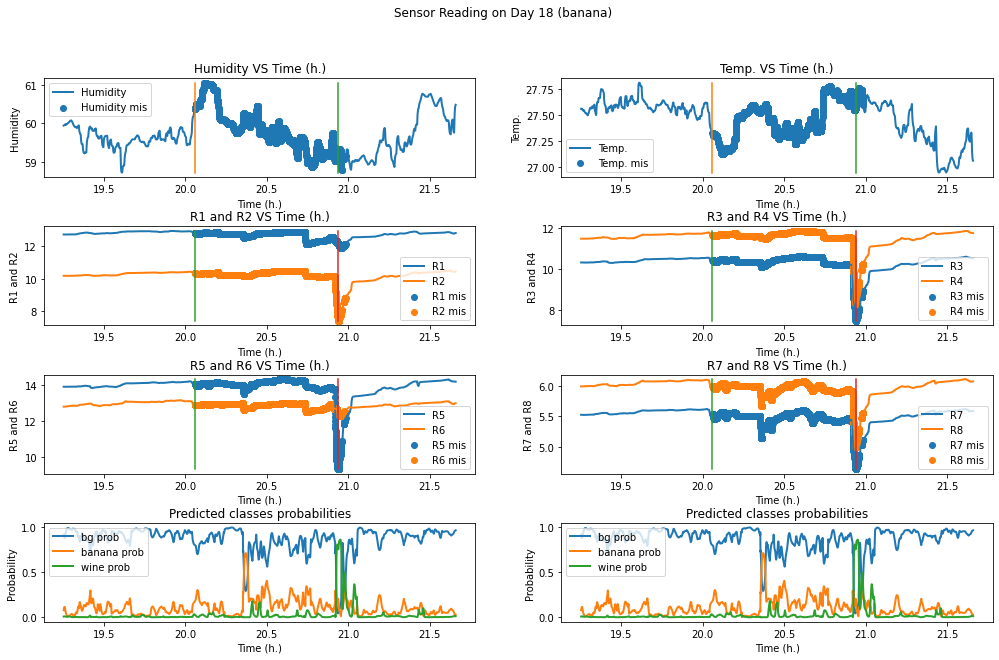

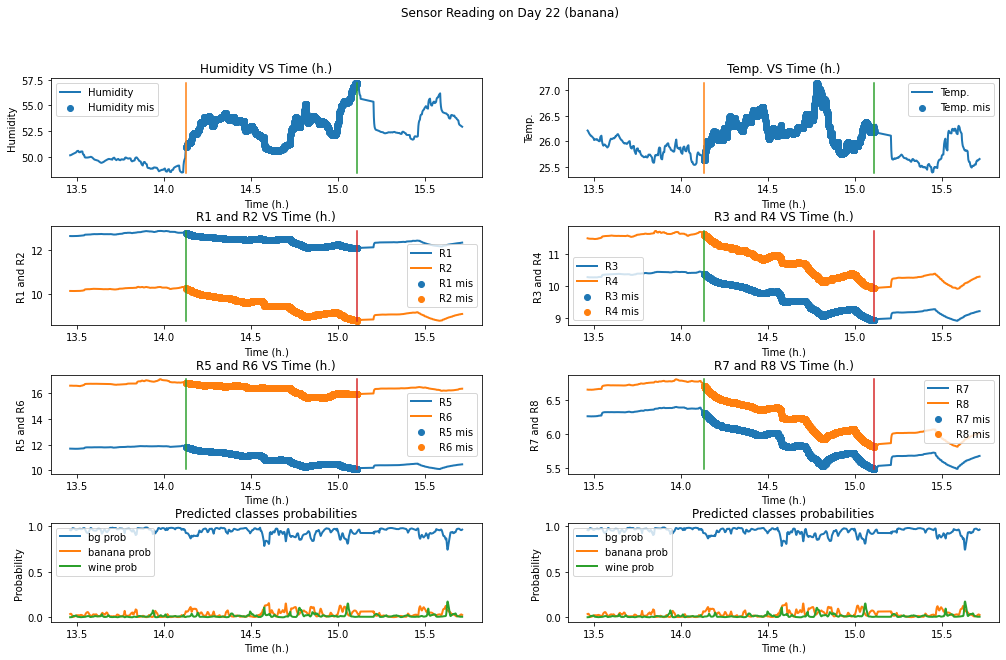

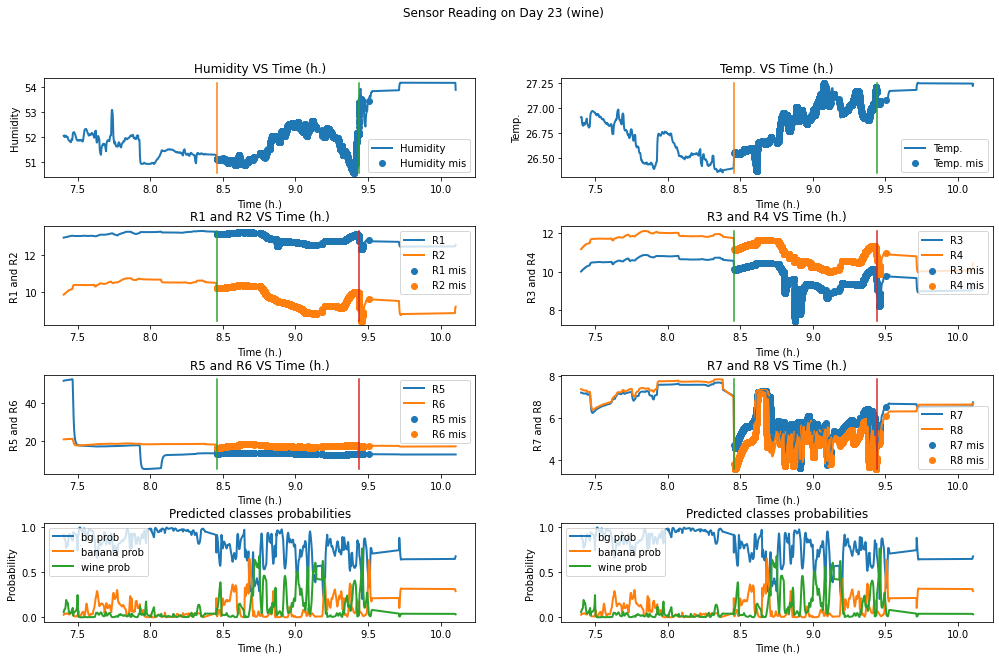

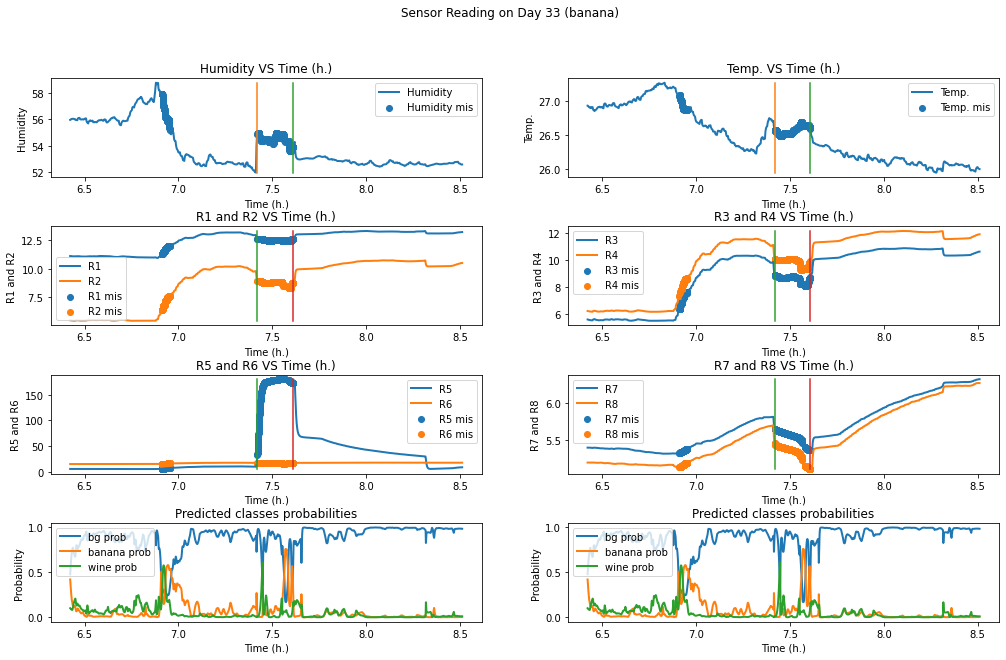

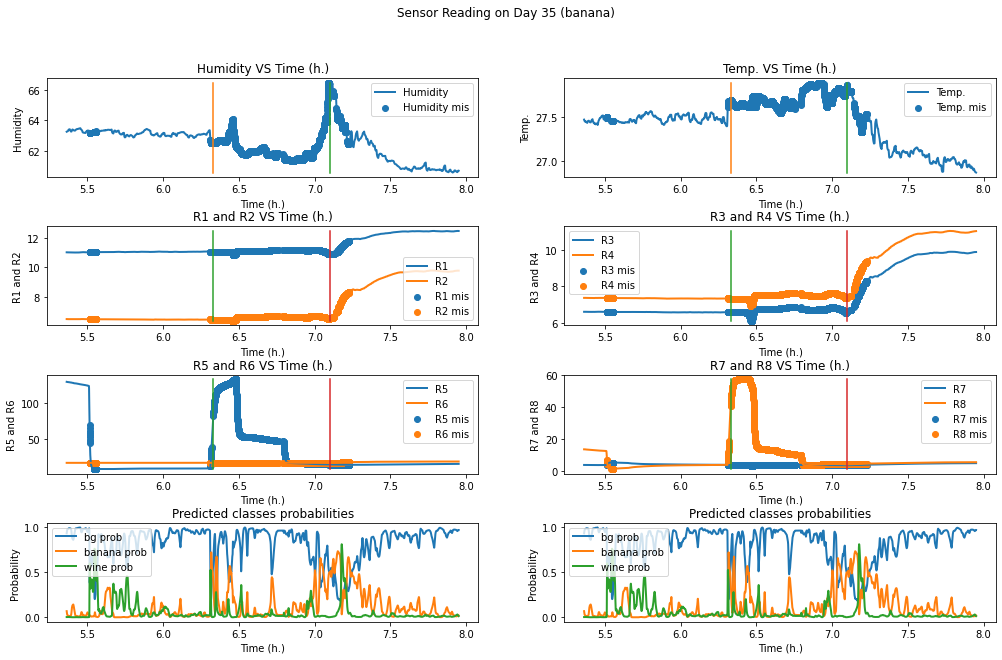

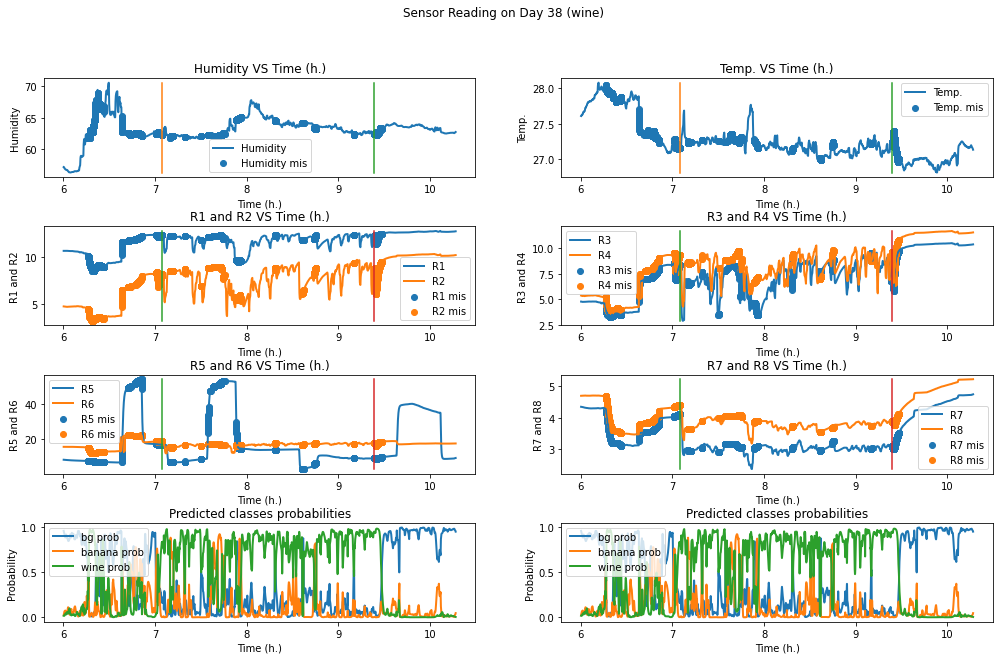

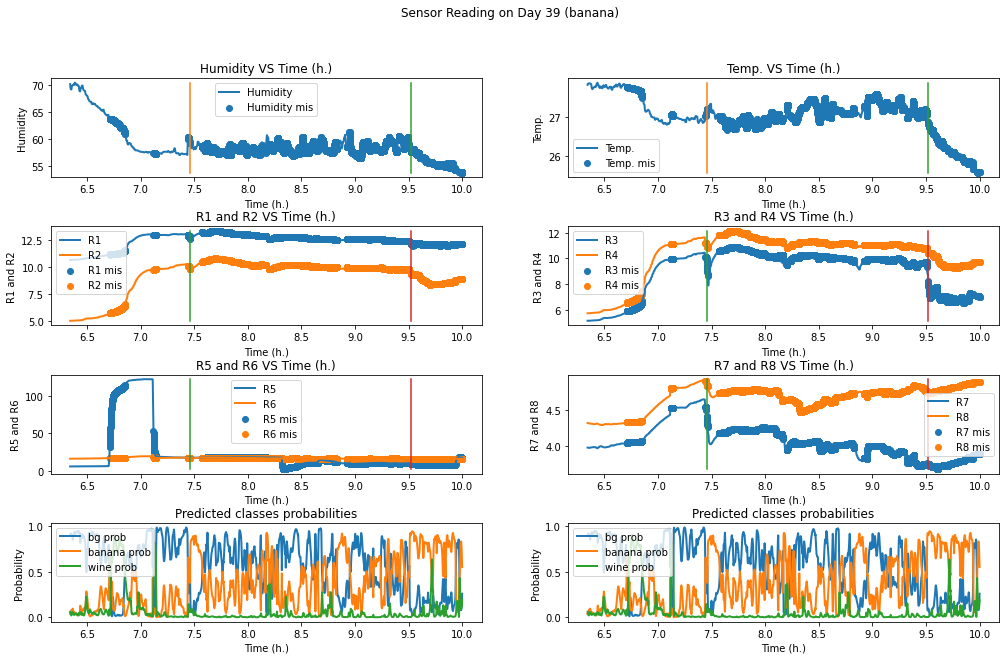

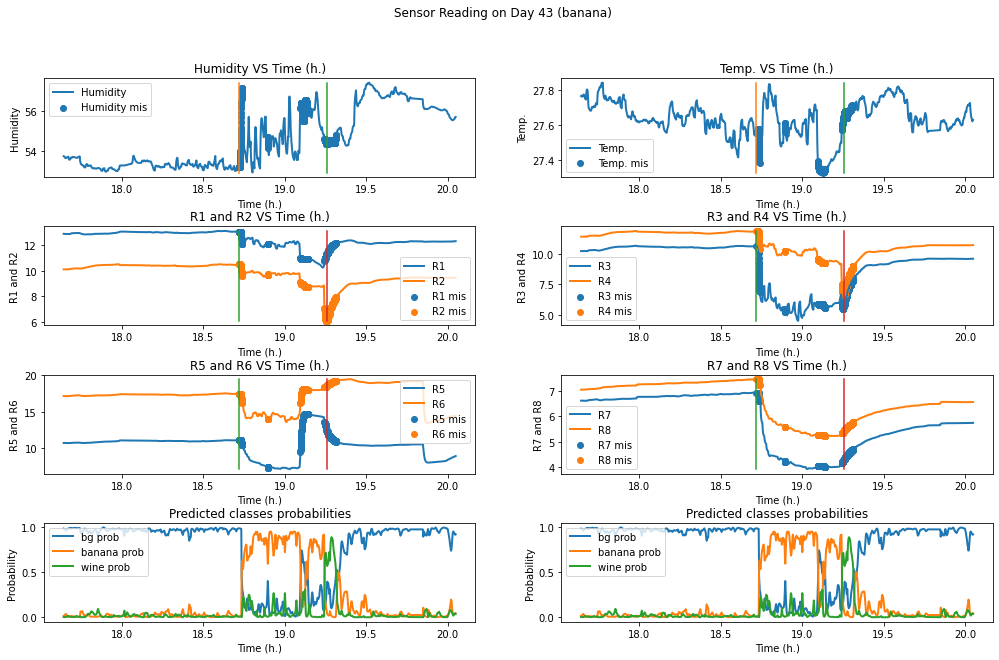

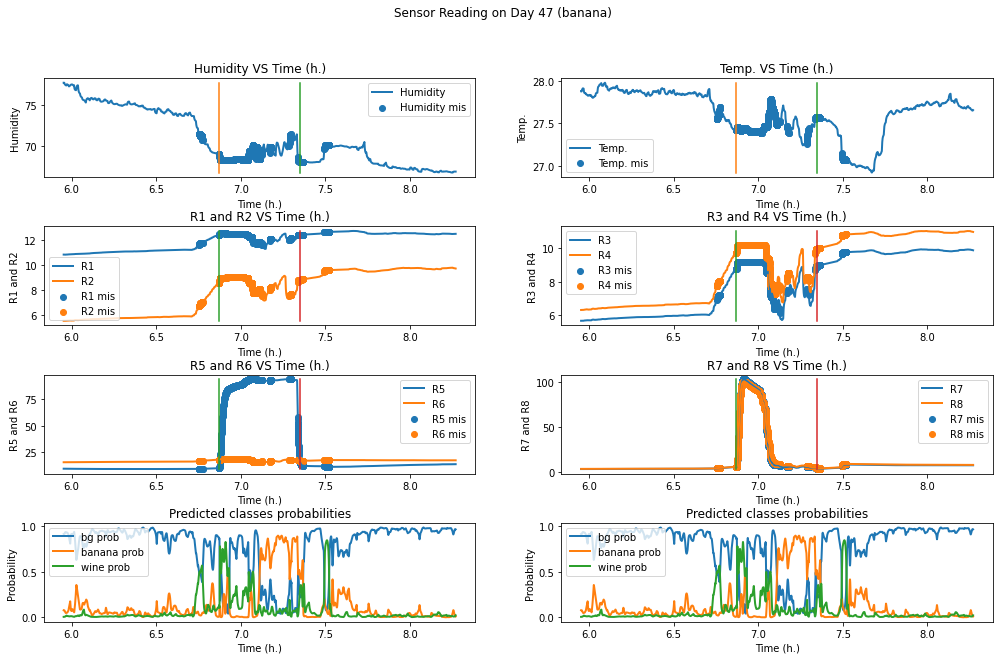

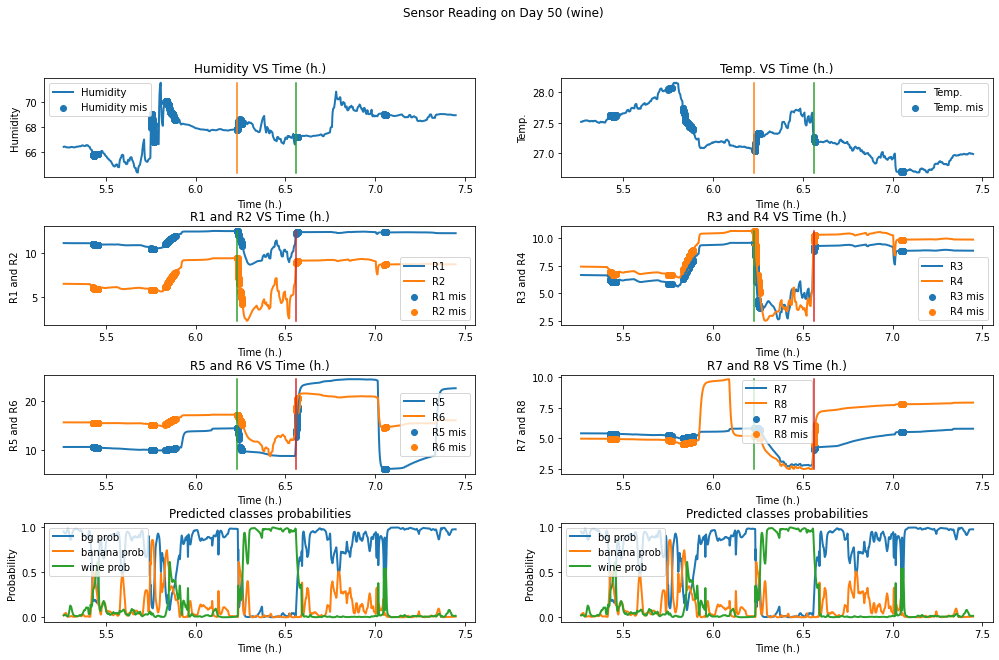

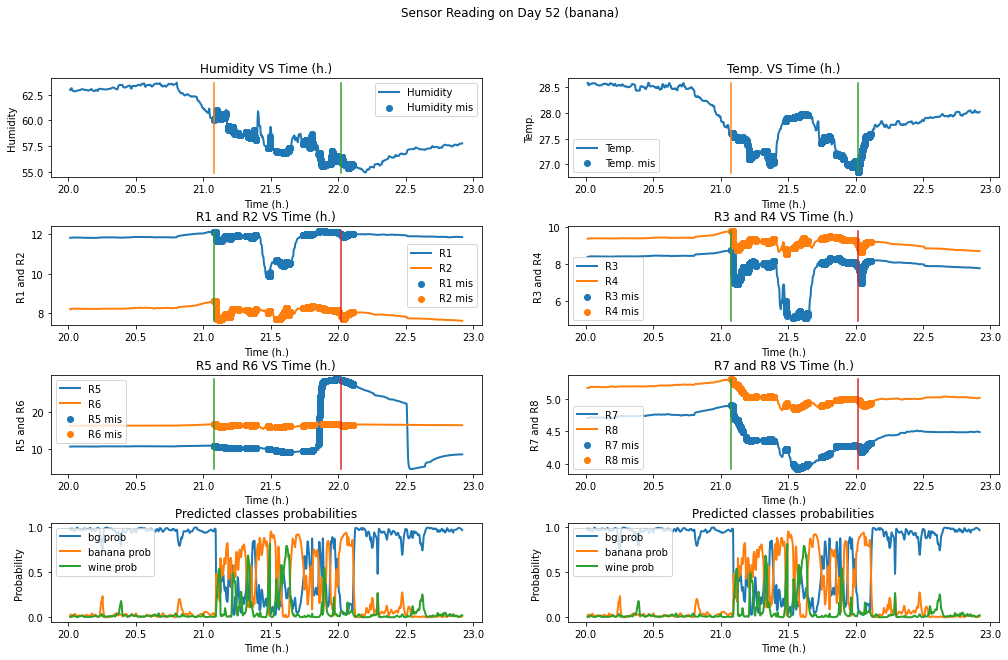

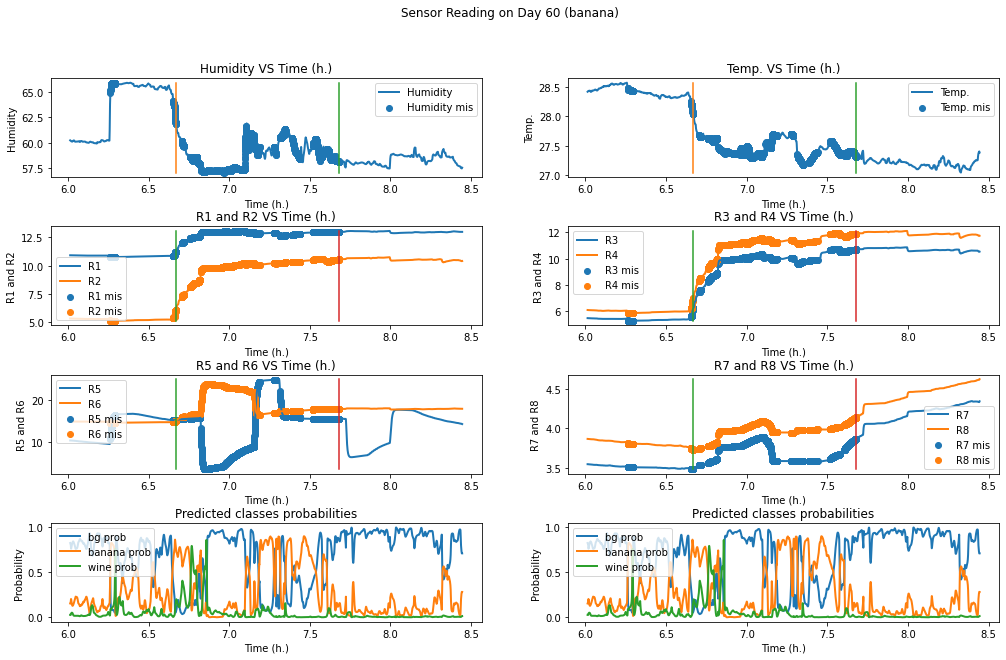

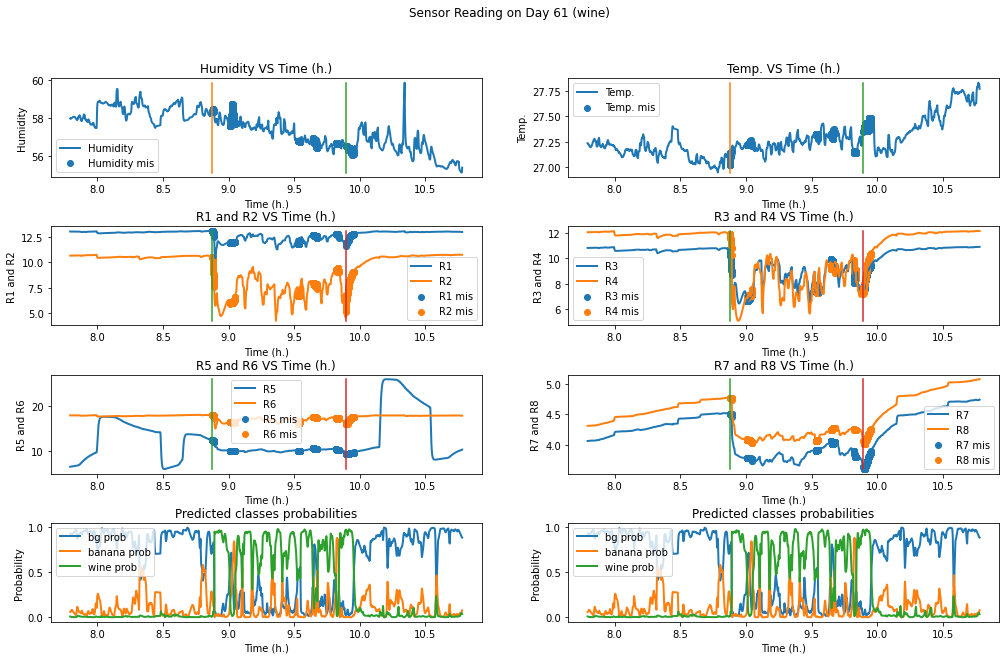

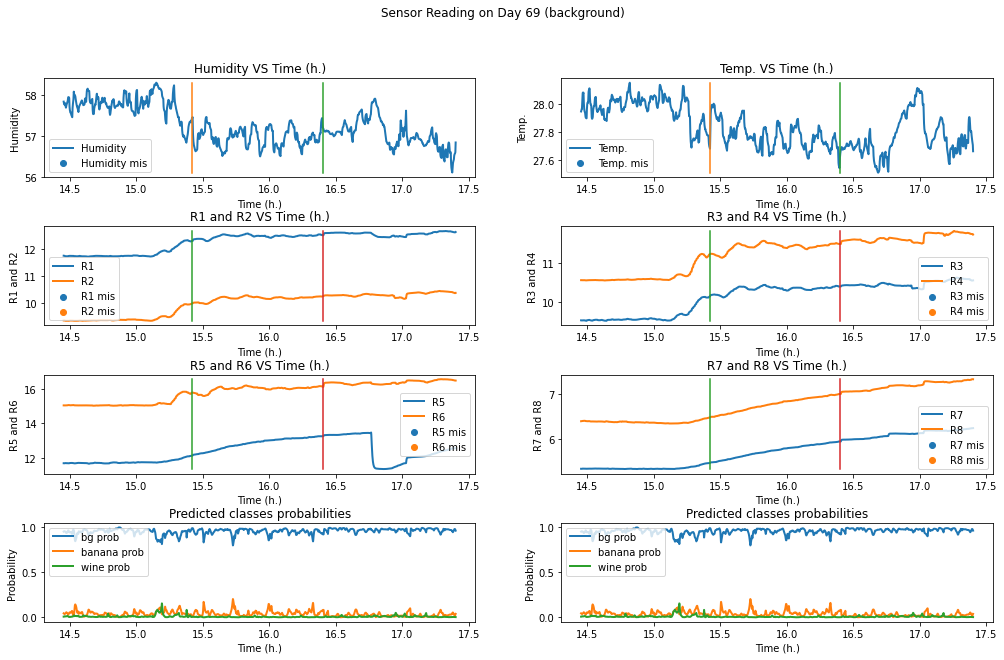

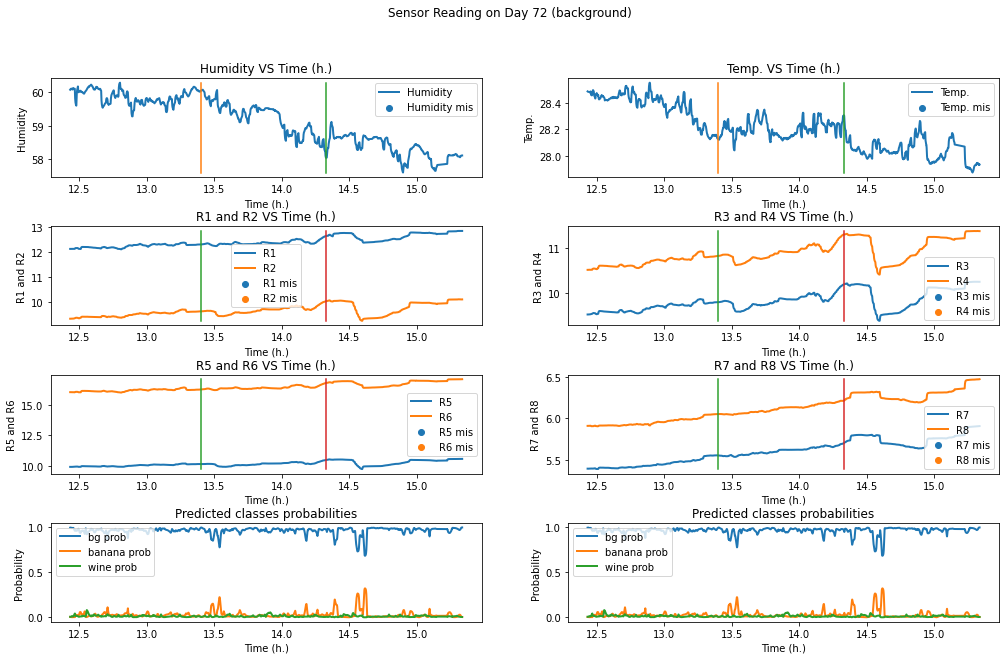

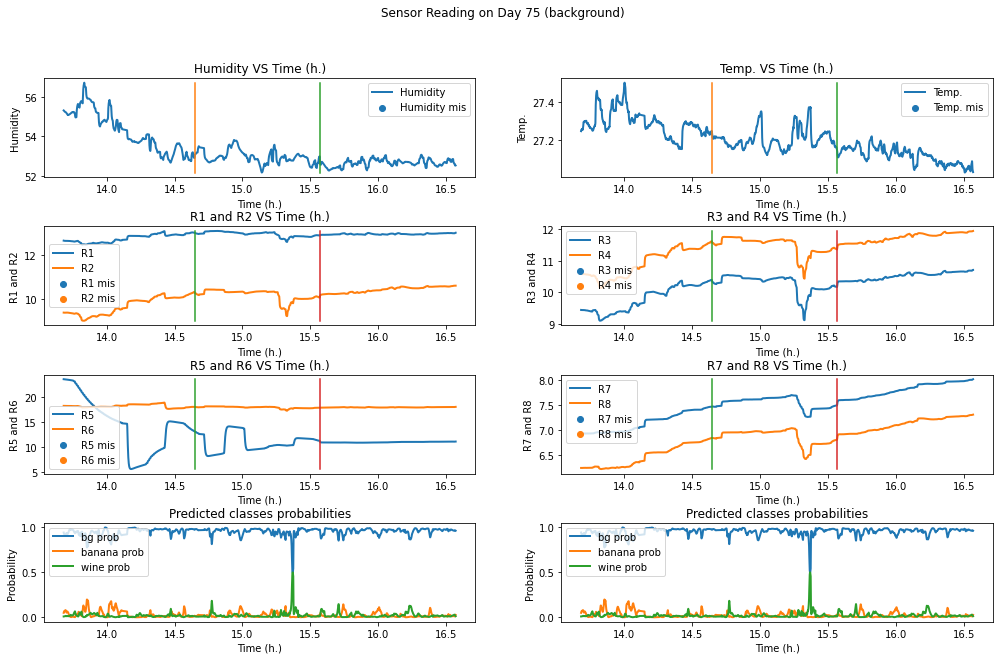

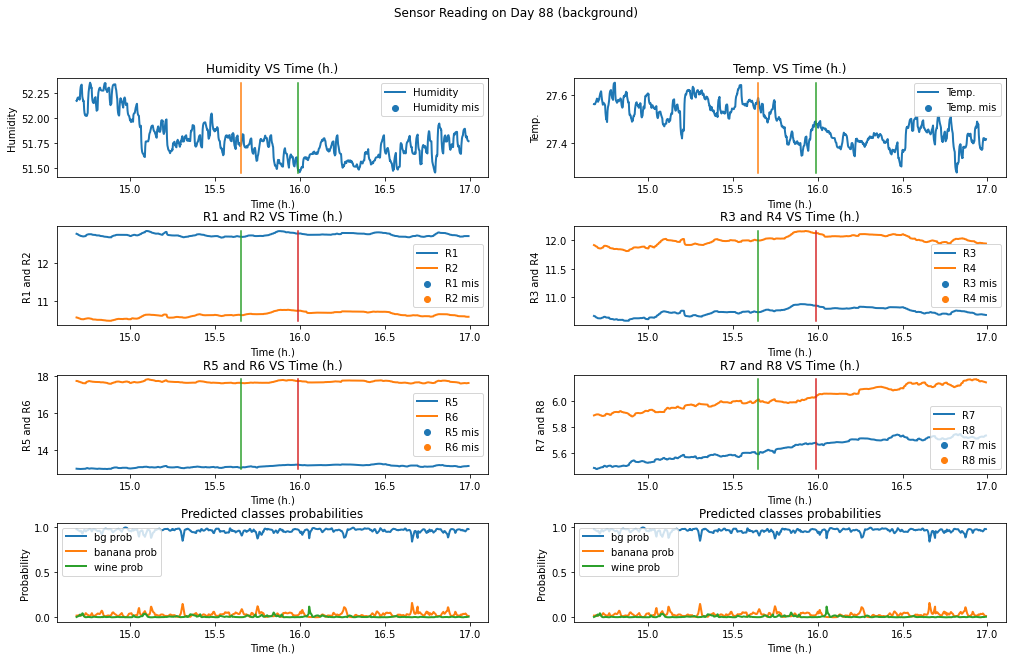

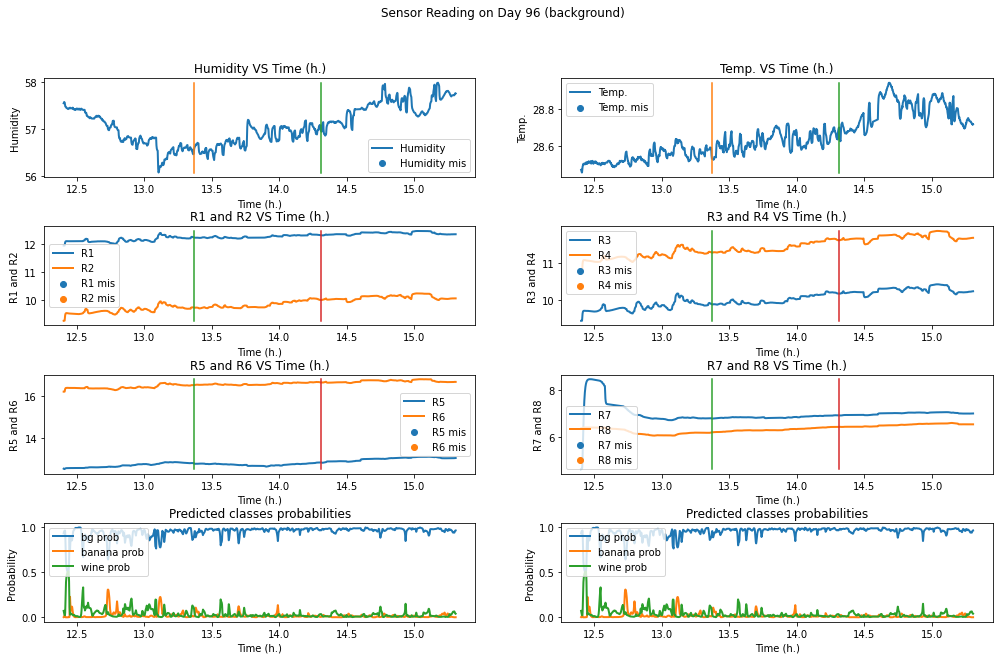

In [42]:
for tid in test_ids:
    plot_misclassified_byID(df_test, tid, ytest, y_pred, probs_mtx=probs)

### Bagging

In [44]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity',
            'R1_mean', 'R2_mean', 'R3_mean', 'R4_mean', 'R5_mean', 'R6_mean', 'R7_mean',
            'R8_mean', 'Temp._mean', 'Humidity_mean', 'R1_std', 'R2_std', 'R3_std', 'R4_std',
            'R5_std', 'R6_std', 'R7_std', 'R8_std', 'Temp._std', 'Humidity_std']

P_BG = []
P_BAN = []
P_WINE = []
ACC = []
R_BG = []
R_BAN = []
R_WINE = []
F1 = []
N_reps = 3
start = time.time()
for i in range(N_reps):
    df_train, df_test = split_series_byID(0.8, win_df)

    xtrain, ytrain = df_train[features].values, df_train['class'].values
    xtest, ytest = df_test[features].values, df_test['class'].values

    chi2_feature = SkewedChi2Sampler(skewedness=0.001, n_components=200, random_state=0)
    clf = SGDClassifier(loss='hinge', max_iter=500, tol=1e-4)
    bc = BaggingClassifier(base_estimator=clf, n_estimators=500, n_jobs=1)

    start_t = time.time()
    X_features = chi2_feature.fit_transform(xtrain, ytrain)
    clf = bc.fit(X_features, ytrain)
    end_t = time.time()


    X_features = chi2_feature.fit_transform(xtest, ytest)

    print('\n>===============================================================<')
    print('Iteración %d' % (i+1) + ' de %d' % N_reps)
    print('Training time (mins):', (end_t-start_t)/60)
    print('>===============================================================<')
    y_pred = clf.predict(X_features)
    occurrences_dict = Counter(ytest)

    # Parámetros interesantes para sacar la media (esto lo he copiado de la func. metric_report) 
    P_BG.append(occurrences_dict['background']/len(ytest)) 
    P_BAN.append(occurrences_dict['banana']/len(ytest))
    P_WINE.append(occurrences_dict['wine']/len(ytest))
    ACC.append(accuracy_score(ytest, y_pred))

    conf_m = confusion_matrix(ytest, y_pred, labels=['background', 'banana', 'wine'])

    R_BG.append(conf_m[0][0]/sum(conf_m[0,:]))
    R_BAN.append(conf_m[1][1]/sum(conf_m[1,:]) )
    R_WINE.append(conf_m[2][2]/sum(conf_m[2,:]))

    F1.append(f1_score(ytest, y_pred, average='weighted'))

end = time.time()
print('\n\n\n>===============================================================<')
print('Total time (mins):', (end-start)/60)
print('>===============================================================<')
print('Mean Accuracy:', np.mean(ACC))
print('Mean Recall on background:', np.mean(R_BG))
print('Mean Recall on banana:', np.mean(R_BAN))
print('Mean Recall on wine:', np.mean(R_WINE))
print('Mean F1-score:', np.mean(F1))
print('>===============================================================<')
print('TEST SET MEAN PROPORTIONS')
print('\tMean background percentage:', np.mean(P_BG))
print('\tMean banana percentage:', np.mean(P_BAN))
print('\tMean wine percentage:', np.mean(P_WINE))


>===============================================================<
Iteración 1 de 3
Training time (mins): 139.73966844081878
>===============================================================<

>===============================================================<
Iteración 2 de 3
Training time (mins): 180.78846943775812
>===============================================================<

>===============================================================<
Iteración 3 de 3
Training time (mins): 151.24085182348887
>===============================================================<



>===============================================================<
Total time (mins): 493.43163247903186
>===============================================================<
Mean Accuracy: 0.8515763468146403
Mean Recall on background: 0.9687527736884549
Mean Recall on banana: 0.2067523926550877
Mean Recall on wine: 0.7026493554656749
Mean F1-score: 0.8268844206465271
>=========================================================